FACE DIRECTION(LEFT & RIGHT) CLASSIFACTION WITH CNN

This code will be classifing head poses in which people looking at a camera will be facing. To accomplish this task we will be using a pre-trained model and topping it off with a little custom CNN architecture.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
from scipy import ndimage
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
import numpy as np



In [2]:
import cv2


In [3]:
def extract_blue_channel(img):
    # Convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define blue color range in HSV
    lower_blue = np.array([110, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask for the blue regions
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Apply the mask to the original image (get only the blue areas)
    res = cv2.bitwise_and(img, img, mask=mask)
    
    # Extract the blue channel from the masked image
    blue_channel = res[:, :, 0]
    
    # Resize the blue channel to the MobileNet input size
    blue_channel_resized = cv2.resize(blue_channel, (224, 224))
    
    # Replicate the blue channel to create a 3-channel image
    blue_three_channel = np.stack((blue_channel_resized,)*3, axis=-1)
    
    # Preprocess the image for MobileNet
    blue_three_channel_preprocessed = preprocess_input(blue_three_channel)
    
    return blue_three_channel_preprocessed

In [4]:
image_size = (224, 224)  
batch_size = 24


In [5]:
datagen1 = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function= extract_blue_channel,  
    validation_split=0.2  # Split into train/validation
)
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,  
    rotation_range=30,  # Rotate images by a small angle
    horizontal_flip=True,  # Important for left/right classification
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2 # Split into train/validation
)

train_generator = datagen.flow_from_directory(
    r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images',  
    target_size=(224, 224),  # Resize images
    batch_size=24,
    class_mode='binary',  #  labels
    subset='training',
    seed=123,  
    shuffle=True    
)

validation_generator = datagen1.flow_from_directory(
     r'C:\Users\emman\Documents\python machine learning\Qoorify\good ones\modified images', 
    target_size=(224, 224),
    batch_size=24,
    class_mode='binary',  
    subset='validation',
    seed=123,  
    shuffle=True     
)

Found 1508 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


AUGMENTING AND PRE-PROCESSING

The dataset consists of 1542 images of people looking towards left or right. The good ones folder is further divided into left folder(776 images) and right folder(766 images). These folders will determine our classes. There are just 2 classes hence the class_mode should be set to binary

Due to the relatively small dataset data augmenting will be needed and particularly in this case horizontal flip(for left and right classification). Aside from this other augmenting techniques will be used to reduce overfitting during training and to get better accuracy in both train and validation set.

The seed has been set manually to ensure reproductibilty and ensure consistent result every time we train.

In [6]:
input_shape=(224,224,1)

In [7]:
from tensorflow.keras.applications import MobileNetV2


base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False,weights="imagenet")

MobileNetV2 from google has been choosen because it is light weight and has exceptional accuracy in image classification.
It will be serving as the base layer for the neural network after removing it's top layer and making remaing layers not trainable

In [8]:
base_model.trainable= False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam


MAKING THE CNN

The base model has been  added to a GlobalAveragePooling2D layer to flatten out the dimensions from the output layer filters and make it easier for use to pass through our remaining layers without dimension errors.

BatchNormalization is used and in more than one layer to normalize the incoming data from the previous layer to reduce complexity and avoid over fitting.The purpose of the dropout layer is regularization of the data and is optional

relu and leaky relu have been applied to the dense neural network as they remove all negative values in the network and leaky relu does this better for hidden layers according to some sources.

sigmoid activation functions keeps values between -1 and 1 and has been proven to be the best output layer for binary classification


In [10]:
classifier = tf.keras.Sequential([
 base_model,
 tf.keras.layers.GlobalAveragePooling2D(),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(128, activation='relu'),
 tf.keras.layers.LeakyReLU(negative_slope=0.01),

 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(64, activation='relu'),
 tf.keras.layers.Dense(1, activation='sigmoid') ])

COMPILING THE NETWORK

The adam is the most common used optimizers because it can monitor the momentum as well as serve as a function to guide the back propergation to the best weights and biases at the right pace.

learning weight was adjusted a few times after training but is essentially the steps taken towards finding the minimum loss during training.

beta1 and beta 2 are the momentum of the Adam optimizer and were set manually because it was not learning as fast as expected but it was obvious from training it was getting somewhere.

binary_crossentropy serves as our loss function particulary because our task is binary classification(left and right)


In [11]:
classifier.compile(optimizer = Adam(learning_rate=0.0015, beta_1=0.95, beta_2=0.999), loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall'])

classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,905 (9.29 MB)

 Trainable params: 175,105 (684.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

\T/RAINING AND VALIDATION

The amount of epochs were changed continously but 40 seems to yeild the best results for now.
Each model is saved because when the results(sccuracy and loss) are approaching optimal values there may be slight variations, this way we can pick the model with the best weight in terms loss and accuracy.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'classifeir_epoch_{epoch:02d}.keras',  # Save model with epoch number in filename
    save_freq='epoch',  # Save weights at every epoch
    verbose=1  # Show saving progress
)

# Train the model with the checkpoint callback
history = classifier.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[checkpoint]  # Add the checkpoint callback
)


From the training output we can say that our network is performing well. The losses for both train and validation reduced after each epoch which shows there is no overfitting and that the model is actually seeing patterns from the images being passed through it.

Validation accuracy is higher than test accuracy showing the model has generalized patterns and is now able to work better with data it has not seen before.

Training and validation losses are to be closw to 0.1 and in most epochs towards the end train loss was close to 0.3 and validation close to 0.1999. These are fair results considering the little data given.

We can see the momentum per step played a role in the training during the epochs and we shall be going with epoch 40 for our final model.

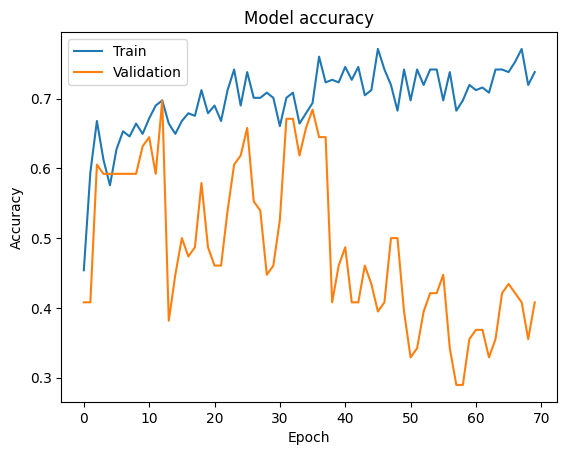

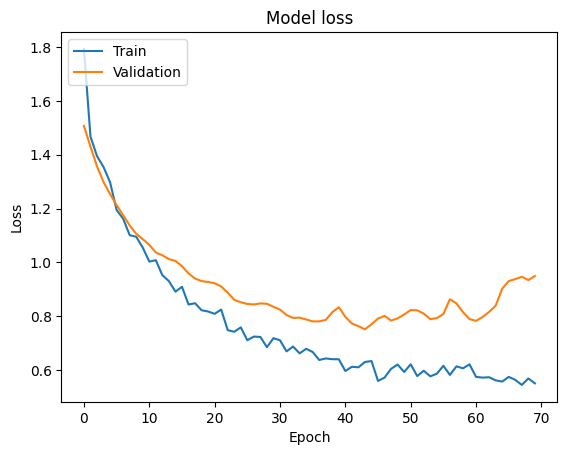

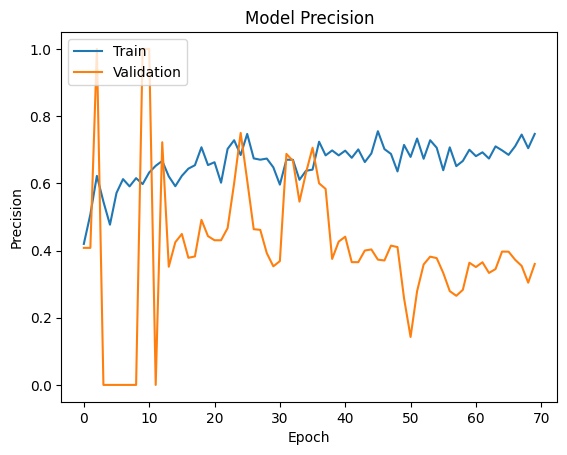

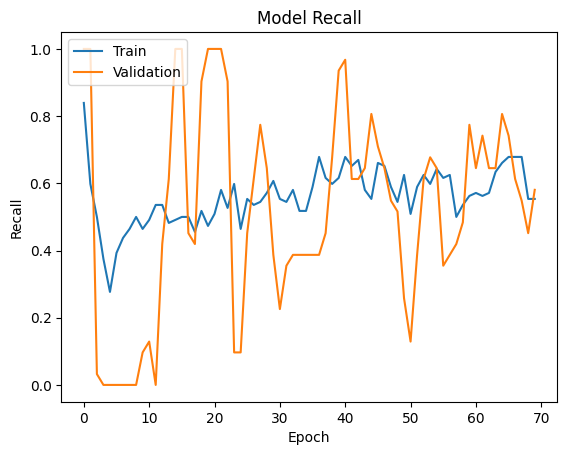

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['Precision'])
plt.plot(history.history['val_Precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['Recall'])
plt.plot(history.history['val_Recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The graphs further show the analyses from the previous training as well as both loss and accuracy values stabilizing after a point.

In [59]:
from tensorflow.keras.models import load_model

model_epoch_36 = load_model(r'C:\Users\emman\Documents\python machine learning\Qoorify\experimentation\classifeir_epoch_60.keras')


In [60]:
datagen3= ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

In [ ]:
dataset = datagen3.flow_from_directory(
    r'C:\Users\emman\Documents\python machine learning\Qucoon-Liveliness\Qucoon-Liveliness',  
    target_size=(224, 224),
    batch_size=24,
    class_mode= 'binary',   
    seed=123,  
      )

Found 51 images belonging to 2 classes.


In [62]:
model_epoch_36.evaluate(dataset)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - Precision: 0.5786 - Recall: 0.3054 - accuracy: 0.5460 - loss: 0.9530


[0.9573057293891907, 0.529411792755127, 0.5714285969734192, 0.3076923191547394]

In [15]:
from IPython.display import clear_output  # Import clear_output


In [16]:
predictions = []
true_labels = []

for images, labels in dataset:
    # Predict the class probabilities
    preds = model_epoch_36.predict(images)
    # Convert probabilities to class labels (0 or 1)
    preds = (preds > 0.5).astype(int)
    
    # Append predictions and true labels
    predictions.extend(preds.flatten())
    true_labels.extend(labels.flatten())
    
    # Break after one full pass through the dataset
    if len(predictions) >= dataset.samples:
        break

clear_output(wait=True)  # wait=True will ensure the output is cleared before displaying new output

# Generate and print classification report
report = classification_report(true_labels, predictions)
print(report)

ValueError: too many values to unpack (expected 2)

In [15]:
predictions2 = []
preds2 = model_epoch_36.predict(dataset)


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step


In [16]:
print(preds2[:19].flatten())         # Probabilities
      # True labels

[0.9699025  0.02374835 0.9981798  0.9989177  0.08567896 0.9289554
 0.99856865 0.9837572  0.1639117  0.01571059 0.9872942  0.00393749
 0.00652765 0.9080199  0.00373726 0.82534134 0.9991534  0.0037266
 0.98600465]


In [ ]:
import cv2

def calculate_brightness(image):
    # Convert to a NumPy array
    img_array = image.numpy()
    
    # Convert to grayscale (OpenCV expects uint8, so convert from float32)
    gray_img = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # Calculate and return the mean brightness of the grayscale image
    brightness = np.mean(gray_img)
    return brightness

def calculate_average_brightness(dataset):
    total_brightness = 0
    image_count = 0
    
    for images, labels in dataset:
        for image in images:
            # Compute brightness for each image
            brightness = calculate_brightness(image)
            total_brightness += brightness
            image_count += 1
    
    # Return average brightness across all images in the dataset
    return total_brightness / image_count if image_count > 0 else 0


# Calculate average brightness of the dataset
average_brightness = calculate_average_brightness(dataset)
print(f'Average brightness of the dataset: {average_brightness}')


In [ ]:
def spoof_predict_with_brightness_check(img_path, model, brightness_threshold=100):
    brightness = calculate_brightness(img_path)
    
    # Check if the brightness meets the threshold
    if brightness < brightness_threshold:
        print(f"Image brightness ({brightness}) is below the threshold ({brightness_threshold}). Skipping...")
        return None  # Skip this image
    
    print(f"Image brightness ({brightness}) is sufficient. Proceeding with prediction...")